In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import emcee
from scipy.integrate import quad
from scipy.integrate import simps
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'xtick.major.size': 5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })

Text(0, 0.5, 'N Clouds')

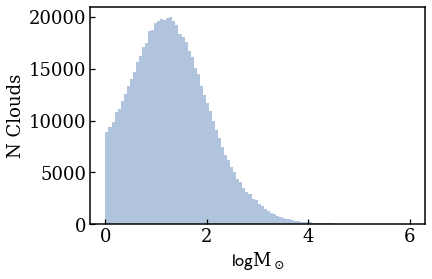

In [198]:
os.chdir("/Users/helenarichie/GitHub/ASTR-3705-Class-Project/src/")

res512, res1024, res2048 = np.load("../data/masses.npy", allow_pickle=True)

res = 2048
colors = "lightsteelblue"
fcolors = "indianred"
masses = res2048 * cell_vol_kpc(res)
xmin = 1
massind = np.where(masses > xmin)
masses1 = masses[massind]

nbins = 100

def cell_vol_kpc(res):
    return (10.0 / float(res)) ** 3

n2048, bins2048, patches2048 = plt.hist(np.log10(masses1), bins=nbins, color=colors, label=r"$R={2048}$")
plt.xlabel("$\log M_\odot$")
plt.ylabel("N Clouds")

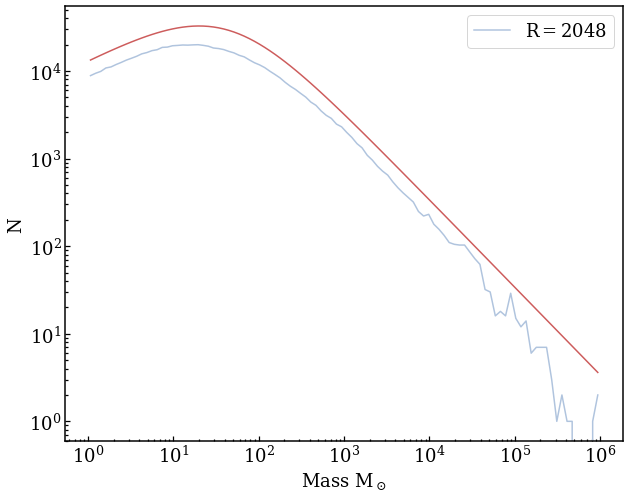

In [238]:
a1 = -0.5
a2 = 1
mpeak = 40
delta = 1
A = 3e4

x = (bins2048[1:] + bins2048[:-1]) / 2.
center_mass = 10 ** x

fm = A * (center_mass / mpeak) ** (-a1) * (0.5 * (1 + (center_mass / mpeak) ** (1 / delta))) ** ((a1 - a2) / delta)

fig = plt.figure(figsize=(10, 8))
plt.plot(center_mass, n2048, label=f"$R={res}$", color=colors)
plt.plot(center_mass, fm, color=fcolors)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mass$~M_\odot$")
plt.ylabel("N")
plt.legend()
plt.show()

In [174]:
def model(mass, theta):
    """Broken power law model with 4 free parameters used to model the
    behavior of the cloud mass probability distribution.
    """
    mpeak, a1, a2, delta = theta
    return (mass / mpeak) ** (-a1) * (0.5 * (1 + (mass / mpeak) ** (1 / delta))) ** ((a1 - a2) * delta)

def lnlike(theta, mass, xmin):
    """Compute the likelihood of the data given the model.
    """
    mpeak, a1, a2, delta = theta
    # calculate broken power-law model for the current set of parameters
    mod = model(mass, theta)
    A = quad(model, xmin, 10 ** 7, args=theta)[0]
    likenorm = mod / A
    # calculate the likelihood
    likelihood = np.sum(np.log(likenorm))
    if not np.isfinite(likelihood):
            return -np.inf
    return likelihood

a1low, a1up = -10, -1e-9
a2low, a2up = 1e-9, 10
mpeaklow, mpeakup = 1e-9, 50
deltalow, deltaup = 1e-9, 10
def lnprior(theta):
    mpeak, a1, a2, delta = theta
    if not (a1 >= a1low, a1 <= a1up):
        return -np.inf
    if not (a2 >= a2low, a2 <= a2up):
        return -np.inf
    if not (mpeak >= mpeaklow, mpeak <= mpeakup):
        return -np.inf
    if not (delta >= deltalow, delta <= deltaup):
        return -np.inf
    # assume a flat prior 
    return 0.0

def lnprob(theta, mass, xmin):
    mpeak, a1, a2, delta = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
            return -np.inf
    return lp + lnlike(theta, mass, xmin)

In [200]:
data = (masses1, xmin)
nwalkers = 100
niter = 100
theta0 = np.array([mpeak, a1, a2, delta])
ndim = len(theta0)
p0 = [np.array(theta0) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [184]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [185]:
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)

Running burn-in...


<ipython-input-174-d1bb590d83a1>:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  A = quad(model, xmin, 10 ** 7, args=theta)[0]
<ipython-input-174-d1bb590d83a1>:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A = quad(model, xmin, 10 ** 7, args=theta)[0]
<ipython-input-174-d1bb590d83a1>:17: RuntimeWarning: invalid value encountered in log
  likelihood = np.sum(np.log(likenorm))
<ipython-input-174-d1bb590d83a1>:6: RuntimeWarning: overflow encountered in power
  return (mass / mpeak) ** (-a1) * (0.5 * (1 + (mass / mpeak) ** (1 / delta))) ** ((a1 - a2) * delta)
<ipython-input-174-d1bb590d83a1>:6: RuntimeWarning: overflow encountered in double_scalars
  return (mass / mpeak) ** (-a1) * (0.5 * (1 + (mass / mpeak) ** (1 / delta))) ** ((a1

Running production...


<ipython-input-174-d1bb590d83a1>:6: RuntimeWarning: invalid value encountered in multiply
  return (mass / mpeak) ** (-a1) * (0.5 * (1 + (mass / mpeak) ** (1 / delta))) ** ((a1 - a2) * delta)
<ipython-input-174-d1bb590d83a1>:17: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(likenorm))
<ipython-input-174-d1bb590d83a1>:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  A = quad(model, xmin, 10 ** 7, args=theta)[0]


In [236]:
def plotter(sampler, mass=center_mass, n=n2048):
    """
    mass : center mass of each bin in bins2048 in solar masses
    n2048 : number of clouds in each bin in bins2048
    """
    fig = plt.figure(figsize=(10, 8))
    data_norm = n2048 / np.sum(n2048)
    plt.loglog(mass, data_norm, label="Data", color="k")
    samples = sampler.flatchain
    # bin width in solar masses
    dM = 10 ** (bins2048[1:] - bins2048[:-1])
    for theta in samples[np.random.randint(len(samples), size=100)]:
        pM = model(mass, theta)
        A = quad(model, xmin, 10 ** 7, args=theta)[0]
        expectation_value = pM * n2048 * dM / A
        plt.loglog(mass, expectation_value, c="r", alpha=0.1)
    plt.plot(0, label="MCMC", color="r")
    plt.legend()
    plt.xlabel("Mass$~[M_\odot]$")
    plt.ylabel("N (normalized)")
    plt.show()

<ipython-input-236-cc83257f2c52>:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  A = quad(model, xmin, 10 ** 7, args=theta)[0]
<ipython-input-236-cc83257f2c52>:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  A = quad(model, xmin, 10 ** 7, args=theta)[0]
<ipython-input-236-cc83257f2c52>:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained

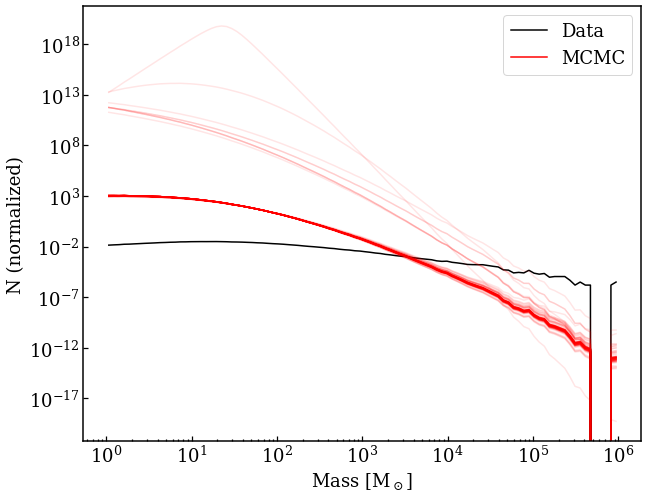

In [237]:
plotter(sampler)